# Import

In [1]:
import numpy as np
import pandas as pd
import os
import math

from scipy import stats #Analysis 
from scipy.stats import norm 

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [2]:
# 한글 폰트가 깨지면 실행하세요! 
# 한글 폰트가 따로 깔려있지 않은 컴퓨터에서는 해당 cell을 넘겨주세요!!! 
import matplotlib.font_manager as fm
fontlist = fm.findSystemFonts(fontpaths = None, fontext='ttf')
# 아래 주석을 지워서 폰트 리스트를 확인하고 한글 폰트를 font_path에 추가합니다
fontlist[:]

from matplotlib import font_manager, rc
#font_path = 'C:\\Users\\mtang\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquare.ttf'
font_path = 'C:\\WINDOWS\\Fonts\\NanumGothicLight.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 1. Data Load  

**치매 예방을 위한 라이프로그 치매 분류**

**9,327 rows × 66 columns**

For more details https://aihub.or.kr/problem_contest/nipa-learning-platform/6

In [3]:
path = "./Dataset/"

# original data : data 
data =  pd.read_csv(path + "dementia_data.csv", parse_dates=['summary_date']) # 애초에 datatime 유형의 데이터를 읽어 올 때부터 형변환하기
data

,EMAIL,summary_date,activity_average_met,activity_cal_active,activity_cal_total,activity_class_5min,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,...,sleep_temperature_deviation,sleep_temperature_trend_deviation,timezone,sleep_total,CONVERT(activity_class_5min USING utf8),CONVERT(activity_met_1min USING utf8),CONVERT(sleep_hr_5min USING utf8),CONVERT(sleep_hypnogram_5min USING utf8),CONVERT(sleep_rmssd_5min USING utf8),DIAG_NM
0,nia+404@rowan.kr,2020-11-27,1.71875,730,2944,...,14346,0,417,0,...,-0.12,99.99,NaN,\r,2/1/1/1/1/1/2/2/1/1/1/1/1/1/2/2/2/3/2/2/2/2/2/...,0.9/0.9/1.4/1.9/1.1/0.9/0.9/1.1/1.3/1/0.9/1.1/...,0/73/73/73/72/71/70/71/71/71/70/70/73/72/74/74...,4/2/4/3/3/1/2/2/2/2/2/2/3/3/3/4/4/3/2/2/2/2/2/...,0/10/10/10/11/11/10/12/18/13/14/12/10/10/18/17...,CN
1,nia+404@rowan.kr,2020-11-28,1.40625,342,2449,...,6352,0,473,0,...,-0.32,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/2/2/2/2/...,1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,69/70/69/69/70/72/71/72/70/69/69/69/68/68/63/6...,2/4/2/2/2/2/3/1/2/2/4/4/2/2/2/2/2/2/2/2/2/2/4/...,23/23/26/24/18/13/15/14/17/20/24/30/23/25/22/1...,CN
2,nia+404@rowan.kr,2020-11-29,1.46875,401,2544,...,7297,0,586,0,...,0.07,99.99,NaN,\r,1/1/1/1/1/1/1/2/1/1/1/1/2/2/2/2/2/1/1/1/1/1/2/...,1.1/1.1/1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/74/73/73/74/74/74/71/71/70/70/69/70/68/66/69...,4/2/4/4/1/1/1/4/4/4/4/4/4/4/2/3/4/2/2/4/2/2/2/...,0/11/14/20/13/14/14/16/27/29/27/20/19/19/14/12...,CN
3,nia+404@rowan.kr,2020-11-30,0.34375,27,1850,...,491,0,176,0,...,-0.41,99.99,NaN,\r,2/1/2/2/1/2/1/1/2/1/1/1/1/1/2/1/1/1/1/1/2/2/2/...,0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/...,73/70/71/72/75/75/73/70/70/70/67/63/63/63/63/6...,4/4/4/4/3/3/3/2/4/4/4/2/2/2/2/2/2/2/2/4/2/2/2/...,24/28/19/17/12/10/17/20/23/23/25/31/26/25/34/3...,CN
4,nia+404@rowan.kr,2020-12-01,1.46875,333,2518,...,5861,0,646,0,...,-0.27,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/3/3/2/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/0/0/0/0/0/0/0/69/69/71/69/65/66/64/64/65/66/...,4/4/4/4/4/4/4/4/4/4/4/2/2/2/2/3/3/2/4/4/4/2/2/...,0/0/0/0/0/0/0/0/21/22/26/23/19/29/22/17/14/13/...,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,nia+206@rowan.kr,2020-12-22,1.34375,227,2316,...,3863,3,735,2,...,-0.16,99.99,NaN,\r,2/1/1/2/2/1/1/1/1/2/2/3/2/1/1/1/1/1/1/1/1/1/1/...,1.1/1.4/1.2/0.9/1.2/1.1/0.9/0.9/0.9/1/0.9/0.9/...,0/54/54/54/55/56/0/0/55/52/52/53/54/54/56/57/6...,4/4/4/2/2/2/2/4/2/2/2/1/1/1/1/4/2/2/3/3/3/3/3/...,0/35/39/28/26/41/0/0/52/31/27/30/21/22/27/40/3...,CN
9323,nia+206@rowan.kr,2020-12-24,1.34375,249,2351,...,4411,1,780,4,...,-0.09,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/2/3/2/2/2/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,68/66/67/67/68/69/69/70/71/71/71/69/72/70/70/7...,4/4/2/2/2/1/1/1/1/1/1/2/2/3/3/2/2/2/2/2/3/4/2/...,26/16/19/18/16/18/19/17/15/16/15/13/11/13/13/1...,CN
9324,nia+206@rowan.kr,2020-12-26,1.53125,570,2682,...,11057,1,518,1,...,0.41,99.99,NaN,\r,1/1/1/1/1/1/2/2/2/2/2/2/1/1/1/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/1.1/0.9/0.9/1.1/0.9/0.9/0.9/0....,0/0/65/65/66/67/69/72/73/72/73/74/73/74/75/75/...,4/4/2/2/2/2/2/2/2/2/2/2/4/4/4/4/2/3/3/3/2/2/4/...,0/0/13/12/12/13/12/12/12/16/13/12/13/17/13/18/...,CN
9325,nia+206@rowan.kr,2020-12-27,1.34375,295,2331,...,5135,4,578,0,...,0.27,99.99,NaN,\r,1/1/1/2/3/2/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,1.1/0.9/0.9/0.9/1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/...,0/0/0/64/64/64/64/65/65/66/66/66/66/68/68/68/6...,4/4/4/4/2/2/2/2/2/2/2/2/2/3/3/3/3/2/4/4/2/2/2/...,0/0/0/14/17/18/14/14/17/15/17/12/17/12/13/12/1...,CN


# 2. EDA  

**9,327 rows × 66 columns**

148명에 대한 데일리 라이프로그 데이터  
크게 **1. 기본 정보 2. 걸음거리 3.수면 4.컨버팅 데이터**로 나눌 수 있겠습니다. 

**1. basic (3 cols)**
- timezone 시간 장소 정보 
    - drop 
    - 완벽한 null variable 
- EMAIL
    - drop
    - 식별자 feature 
- summary_date
    - pandas datetime type으로 사용

**2. activity (26 cols)**
- activity_class_5min, activity_met_1min, 하루간 5분당 활동 로그,하루간 1분당 MET 로그
    - drop 
    - BLOB type -> js로 읽을 수 있다고는 함 

**3. sleep (31 cols)**
- sleep_is_longest, 본 수면 여부 
    - 전부 다 1 
- sleep_temperature_trend_deviation, 피부 온도 경향 편차 
    - 전부 다 99.99
- sleep_total, 수면 시간 
    - 전부 다 \r
- sleep_temperature_deviation 
    - drop 
    - sleep_temperature_delta 랑 같은 변수 
    - sleep_temperature_deviation 을 drop 하고 delta를 남길 것 
- sleep_hr_5min, sleep_hypnogram_5min, sleep_rmssd_5min
    - 5분 당 심박동로그, 수면 상태 로그, 5분당 심박동변동 로그
    - drop 
    - BLOB type 

**4. converting**
- CONVERT(activity_class_5min USING utf8)    
- CONVERT(activity_met_1min USING utf8)      
- CONVERT(sleep_hr_5min USING utf8)          
- CONVERT(sleep_hypnogram_5min USING utf8)  
- CONVERT(sleep_rmssd_5min USING utf8) 

**y variable**
- DIAG_NM 
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9327 entries, 0 to 9326
Data columns (total 66 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   EMAIL                                     9327 non-null   object        
 1   summary_date                              9327 non-null   datetime64[ns]
 2   activity_average_met                      9327 non-null   float64       
 3   activity_cal_active                       9327 non-null   int64         
 4   activity_cal_total                        9327 non-null   int64         
 5   activity_class_5min                       9327 non-null   object        
 6   activity_daily_movement                   9327 non-null   int64         
 7   activity_high                             9327 non-null   int64         
 8   activity_inactive                         9327 non-null   int64         
 9   activity_inactivity_alerts    

# 3. Preprocessing 

**9,327 rows × 66 columns**

**9,327 rows × 49 columns**

**===================Default 하게 진행======================**

모델, 알고리즘과 상관없이 반드시 해당 전처리는 수행할 것

**feature drop**
- timezone
- EMAIL
- sleep_temperature_trend_deviation, sleep_is_longest, sleep_total
    - 모든 값이 1, '\r', 99.99 이므로 제거 
- sleep_temperature_deviation
    - sleep_temperature_delta 변수와 중복되므로 deviation 변수를 제거
- activity_class_5min, activity_met_1min
    - convert data
- sleep_hr_5min, sleep_hypnogram_5min, sleep_rmssd_5min
    - convert data

- CONVERT(activity_class_5min USING utf8)    
- CONVERT(activity_met_1min USING utf8)      
- CONVERT(sleep_hr_5min USING utf8)          
- CONVERT(sleep_hypnogram_5min USING utf8)  
- CONVERT(sleep_rmssd_5min USING utf8) 

**===================Optional 하게 진행======================**

각각을 실험해보고 모델과 가장 궁합이 좋은 전처리 기법도 찾아보자

**Scaling**
- Standard Scaler 
- Robust Scaler 

**Transform**
- Log Transform 
- Quantile Transform 

**PCA**

**=========================Y Varible=========================**

- DIAG_NM 
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)
    - Lable Encoding 
    - 모델마다 y 변수를 자동으로 label encoding 기능을 지원하기도 하지만 공통적으로 진행하고 넘어갑시다 
    
So we may use 49 columns for training...

In [7]:
# data를 따로 관리합니다 
# original data -> data 
# preprocessing data -> processed_data
processed_data = data.copy()

In [8]:
# Feature Selection - column drop 
# drop 할 column을 아래와 같이 묶어서 정리합니다 
# summary_date 추가 
drop_cols = ['timezone', 'EMAIL',
             'activity_class_5min', 'activity_met_1min', 
             'sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min',
             'sleep_is_longest', 'sleep_temperature_trend_deviation', 'sleep_total', 'sleep_temperature_deviation',
             'summary_date']
convert_cols = data.iloc[:, 60:65].columns

processed_data = processed_data.drop(drop_cols, axis=1)
processed_data = processed_data.drop(convert_cols, axis=1)
# 9327 x 49 

Optional

In [221]:
# Log Transform and Quantile Transform 
# right skewed -> log transform -> 13개 
# left skewed -> quantile transform -> 8개
# sleep_midpoint_delta -> log tranform에서 error 남 => 제외했음 
# https://yashowardhanshinde.medium.com/what-is-skewness-in-data-how-to-fix-skewed-data-in-python-a792e98c0fa6
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, Normalizer, power_transform, QuantileTransformer 

def quantileTransform(data) : 
    qt = QuantileTransformer()
    scaled_data = pd.DataFrame(qt.fit_transform(data), columns=data.columns)
    return scaled_data

def logTransform(data) :
    scaled_cols = data.columns
    scaled_data = data.apply(lambda x: np.log1p(x))
    return scaled_data

left_skewed_cols = ['sleep_efficiency', 'sleep_score_alignment', 'sleep_score_deep', 'sleep_score_latency', 'sleep_score_total',
                    'activity_score', 'activity_score_stay_active', 'activity_score_training_volume']
right_skewed_cols = ['activity_cal_active', 'activity_daily_movement', 'activity_high', 'activity_medium', 'activity_met_min_high', 
                     'activity_met_min_inactive', 'activity_met_min_low', 'activity_met_min_medium', 'activity_non_wear', 
                     'activity_steps', 'sleep_awake', 'sleep_onset_latency', 'sleep_rmssd']

print(len(left_skewed_cols))
print(len(right_skewed_cols))

processed_data[left_skewed_cols] = quantileTransform(processed_data[left_skewed_cols])
processed_data[right_skewed_cols] = logTransform(processed_data[right_skewed_cols])
processed_data.head()

8
13


,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,DIAG_NM
0,1.71875,6.594413,2944,9.571296,0.0,417,0,545,3.871201,0.0,...,62,1.0,0.112112,50,27,0.912913,66,0.304304,-0.12,CN
1,1.40625,5.837730,2449,8.756682,0.0,473,0,392,2.197225,0.0,...,54,1.0,0.140140,43,46,0.763263,35,0.112112,-0.32,CN
2,1.46875,5.996452,2544,8.895356,0.0,586,0,362,3.218876,0.0,...,61,1.0,0.177177,47,34,0.687688,41,0.304304,0.07,CN
3,0.34375,3.332205,1850,6.198479,0.0,176,0,34,0.693147,0.0,...,55,1.0,0.085586,40,44,0.621622,29,0.226727,-0.41,CN
4,1.46875,5.811141,2518,8.676246,0.0,646,0,377,1.945910,0.0,...,56,1.0,0.217217,55,39,0.008577,54,0.264765,-0.27,CN


In [222]:
# Scaling 
standardScaler = RobustScaler()
scaled_data = processed_data.iloc[:, :48].copy()
scaled_data = pd.DataFrame(standardScaler.fit_transform(scaled_data), columns = scaled_data.columns)
processed_data.iloc[:, :48]=scaled_data

processed_data.head()

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,DIAG_NM
0,1.285714,0.665495,1.086168,0.668473,-0.5,-0.527174,0.0,1.658537,0.075683,-0.663194,...,-0.8125,0.0,-0.807365,-0.941176,-1.857143,0.750000,0.188679,-0.395137,-0.342857,CN
1,-0.142857,-0.231609,-0.036281,-0.233596,-0.5,-0.222826,0.0,0.725610,-1.076056,-0.663194,...,-1.3125,0.0,-0.754485,-1.352941,-1.178571,0.479167,-0.396226,-0.784195,-0.914286,CN
2,0.142857,-0.043432,0.179138,-0.080035,-0.5,0.391304,0.0,0.542683,-0.373133,-0.663194,...,-0.8750,0.0,-0.684608,-1.117647,-1.607143,0.342391,-0.283019,-0.395137,0.200000,CN
3,-5.000000,-3.202093,-1.394558,-3.066443,-0.5,-1.836957,0.0,-1.457317,-2.110900,-0.663194,...,-1.2500,0.0,-0.857413,-1.529412,-1.250000,0.222826,-0.509434,-0.552178,-1.171429,CN
4,0.142857,-0.263132,0.120181,-0.322668,-0.5,0.717391,0.0,0.634146,-1.248967,-0.663194,...,-1.1875,0.0,-0.609065,-0.647059,-1.428571,-0.886651,-0.037736,-0.475177,-0.771429,CN


In [135]:
# PCA
from sklearn.decomposition import PCA

processed_data_y = processed_data['DIAG_NM']
processed_data_X = processed_data.drop('DIAG_NM', axis=1)

pca = PCA(n_components=4)
processed_data_X = pca.fit_transform(processed_data_X)
processed_data_X = pd.DataFrame(processed_data_X)

processed_data = pd.concat([processed_data_X, processed_data_y], axis=1)
processed_data

,0,1,2,3,DIAG_NM
0,-2272.167797,-4082.705104,10869.621333,5460.303368,CN
1,-1873.906100,2416.942852,-5907.759760,1302.340460,CN
2,-3274.713459,-7894.290564,1073.547860,3663.760972,CN
3,-2363.280486,-6632.427668,-5017.978415,793.079395,CN
4,-3301.608111,-6596.087116,-1586.732328,3761.377515,CN
...,...,...,...,...,...
9322,-212.661636,-8805.395903,-3942.173720,-2286.131025,CN
9323,-631.071246,-9610.555311,-2620.013956,-3518.688165,CN
9324,-1361.451197,1315.911394,2094.558774,-3105.802547,CN
9325,2621.706626,-10860.591238,-305.533632,-6249.076234,CN


# 4. Data Split 

모든 전처리와 y variable labeling이 완료되었다.  
train / valid / test data로 분할하고 용도에 맞게 model을 돌리도록 하자. 

In [9]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV

# data를 따로 관리합니다 
# preprocessing data -> processed_data
# input data -> input_data
input_data = processed_data.copy()

# y 변수와 X 변수 분할 관리 
input_data_y = input_data['DIAG_NM'].copy()
input_data_X = input_data.drop(['DIAG_NM'], axis=1)

In [10]:
# LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
input_data_y = le.fit_transform(list(input_data_y))
print("original gain_label \n", le.classes_)
print("gain_lable label \n", set(input_data_y))

original gain_label 
 ['CN' 'Dem' 'MCI']
gain_lable label 
 {0, 1, 2}


In [11]:
# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

# 5. Modeling - ML

- Linear model
    - **Logistic Linear Regression** 
    - solver : newton-cg, lbfgs, sag, saga (sag, saga는 데이터가 클 때 좋음) 
    - newton-cg - (l2, none), lbfgs - (l2, none),  
    - 이중 분류가 아니기 때문에 'liblinear' optimizer를 사용할 수 없음
    - multi_class : default = auto, 현재는 multinomial 
- Tree model 
    - decision Tree (pruning)
    - RandomForest (Ensemble model?)
- Gradient Boosting model 
    - XGB
    - LGBM
    - CatBoost 

In [33]:
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier
from lightgbm import plot_importance 
from xgboost import XGBClassifier
from xgboost import plot_importance
from catboost import CatBoostClassifier
# Learning task parameters
# multi:softmax : softmax를 이용한 다중 클래스 분류 
# multi:softptob : softmax를 이용한 다중 클래스에 대한 예상 확률 반환 
# mlogloss : multiclass logloss 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score

### logistic regression

In [13]:
model_lr = LogisticRegression(max_iter=1000, solver='newton-cg')

In [14]:
# warning : 'max_iter'까지 학습했으나 정답에 수렴하지 못한 상태 
# warning : https://www.inflearn.com/questions/62388 -> 철민이형 답변 
# warning : For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga', 'lbfgs’ handle multinomial loss
# warning : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
model_lr.fit(tr_val_X, tr_val_y)

C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


LogisticRegression(max_iter=1000, solver='newton-cg')

In [15]:
print(model_lr.score(tr_val_X, tr_val_y))
print(model_lr.score(test_X, test_y))

0.6875753920386007
0.6672025723472669


In [16]:
# https://sefiks.com/2021/01/06/feature-importance-in-logistic-regression/ 
# logistic regression interpretability 
w0 = model_lr.intercept_[0]
w = model_lr.coef_[0]

<AxesSubplot:xlabel='importance', ylabel='feature'>

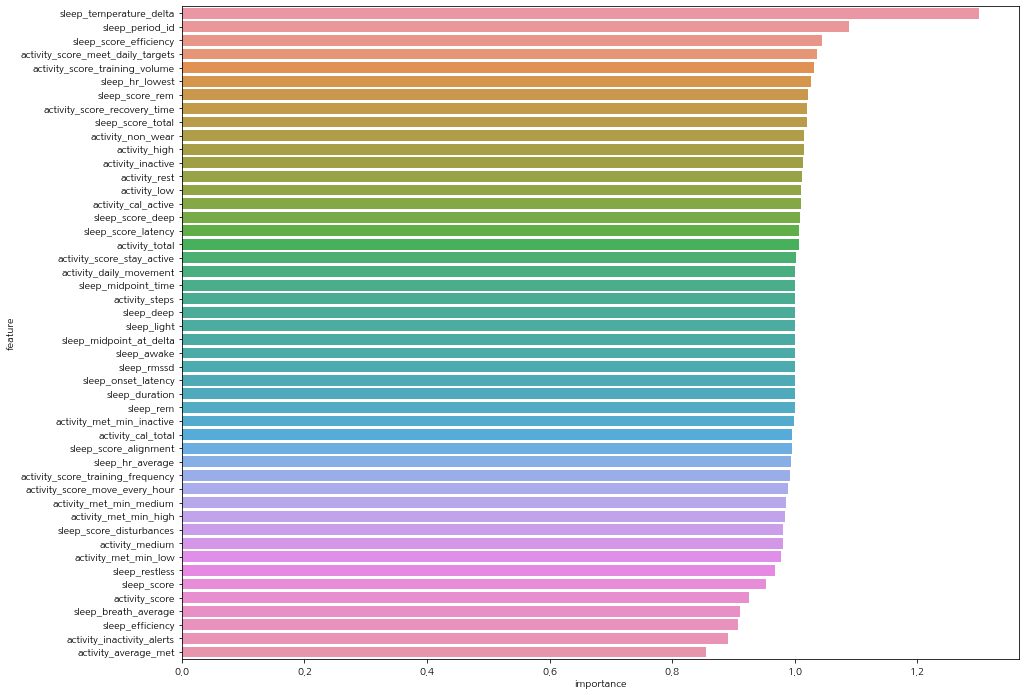

In [17]:
feature_importance = pd.DataFrame(test_X.columns, columns=["feature"])
feature_importance["importance"] = pow(math.e, w)
feature_importance = feature_importance.sort_values(by=["importance"], ascending=False)

plt.figure(figsize = (15,12))
sns.barplot(data=feature_importance, x="importance", y="feature")

In [215]:
# feature importance 가 1 이하인 것들을 제거해보고 진행해봅니다 
# 23개의 feature가 drop 되고 48개에서 25개만 남게 되겠네요
not_necessary = feature_importance[feature_importance["importance"]<1]["feature"].values
print(len(not_necessary))
print(not_necessary)

25
['activity_score_recovery_time' 'sleep_score_efficiency' 'activity_score'
 'sleep_rem' 'activity_met_min_inactive' 'activity_score_move_every_hour'
 'activity_inactivity_alerts' 'sleep_onset_latency'
 'activity_score_training_volume' 'sleep_breath_average'
 'sleep_score_total' 'sleep_score' 'activity_cal_total' 'sleep_deep'
 'activity_score_training_frequency' 'sleep_score_alignment'
 'activity_met_min_high' 'activity_score_stay_active'
 'sleep_score_disturbances' 'activity_rest' 'sleep_restless'
 'activity_inactive' 'activity_cal_active' 'sleep_duration'
 'activity_total']


feature selection 끝! 

In [216]:
input_data_X2 = input_data_X.drop(not_necessary, axis=1)
input_data_X2.head()

,activity_average_met,activity_daily_movement,activity_high,activity_low,activity_medium,activity_met_min_low,activity_met_min_medium,activity_non_wear,activity_score_meet_daily_targets,activity_steps,...,sleep_hr_lowest,sleep_light,sleep_midpoint_at_delta,sleep_midpoint_time,sleep_period_id,sleep_rmssd,sleep_score_deep,sleep_score_latency,sleep_score_rem,sleep_temperature_delta
0,1.285714,0.668473,-0.5,1.658537,0.075683,1.253033,0.155530,0.428226,0.000,0.583640,...,0.777778,0.070707,-0.251153,0.630872,-1.0,-0.762422,-0.807365,0.750000,0.188679,-0.342857
1,-0.142857,-0.233596,-0.5,0.725610,-1.076056,0.483671,-1.065624,0.406597,-0.425,-0.277080,...,0.888889,-0.404040,0.305631,-0.664430,-1.0,-0.857935,-0.754485,0.479167,-0.396226,-0.914286
2,0.142857,-0.080035,-0.5,0.542683,-0.373133,0.432317,-0.328072,0.157293,0.000,-0.189502,...,0.444444,0.196970,-0.434795,0.671141,-1.0,-0.270445,-0.684608,0.342391,-0.283019,0.200000
3,-5.000000,-3.066443,-0.5,-1.457317,-2.110900,-3.125917,-2.267144,0.314586,0.000,-0.221490,...,0.222222,0.292929,-0.170901,0.288591,-1.0,0.000000,-0.857413,0.222826,-0.509434,-1.171429
4,0.142857,-0.322668,-0.5,0.634146,-1.248967,0.432317,-1.211927,0.314586,0.000,-0.336994,...,0.555556,-0.101010,-0.347221,0.617450,-1.0,-0.501019,-0.609065,-0.886651,-0.037736,-0.771429


In [217]:
# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X2, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

In [218]:
model_lr = LogisticRegression(max_iter=1000, solver='newton-cg')
model_lr.fit(tr_val_X, tr_val_y)

print(model_lr.score(tr_val_X, tr_val_y))
print(model_lr.score(test_X, test_y))

0.6508510923468704
0.6484458735262594


중요도 낮은 feature를 pca로 묶어버리기 

In [200]:
pca = PCA(n_components=4)
pca_data = pca.fit_transform(input_data_X[not_necessary])
pca_data = pd.DataFrame(pca_data)

input_data_X = input_data_X.drop(not_necessary, axis=1)
input_data_X = pd.concat([input_data_X, pca_data], axis=1)
input_data_X

,activity_cal_active,activity_daily_movement,activity_high,activity_inactive,activity_low,activity_non_wear,activity_rest,activity_score_meet_daily_targets,activity_score_recovery_time,activity_score_stay_active,...,sleep_score_deep,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,0,1,2,3
0,730,14346,0,417,545,32,399,95,100,86,...,41,27,97,66,62,-0.12,8745.781720,5205.146185,-2217.055436,-129.982015
1,342,6352,0,473,392,29,538,78,100,83,...,49,46,91,35,44,-0.32,-3666.413467,3478.161454,-1003.884596,-135.760461
2,401,7297,0,586,362,9,459,95,100,71,...,56,34,89,41,62,0.07,5743.947920,4793.364710,-612.371108,177.677910
3,27,491,0,176,34,19,1210,95,100,74,...,35,44,86,29,56,-0.41,1566.914313,4112.081227,-17.252671,306.445278
4,333,5861,0,646,377,19,392,95,100,65,...,64,39,14,54,59,-0.27,3812.479386,3925.581880,-1457.715594,2411.314682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,227,3863,3,735,155,0,530,43,100,49,...,53,74,97,84,82,-0.16,3776.910422,-1090.990063,-861.533231,52.362351
9323,249,4411,1,780,167,0,470,25,100,45,...,34,76,81,95,86,-0.09,4314.371906,-1928.102964,-1195.039789,-303.342512
9324,570,11057,1,518,332,0,528,43,100,76,...,1,69,86,89,64,0.41,-1081.506508,-598.825466,-2319.799570,-185.272605
9325,295,5135,4,578,173,0,655,25,100,70,...,9,86,89,98,97,0.27,6146.706837,-3876.112537,-1455.732410,417.369144


In [201]:
# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

model_lr = LogisticRegression(max_iter=1000, solver='newton-cg')
model_lr.fit(tr_val_X, tr_val_y)

print(model_lr.score(tr_val_X, tr_val_y))
print(model_lr.score(test_X, test_y))

C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Hyeongbin\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hyeongbin\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


0.6629138185229861
0.662379421221865


C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


### Random Forest

In [18]:
model_rf = RandomForestClassifier()

In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X.iloc[train_index], input_data_X.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_rf.fit(x_train, y_train)
    pred = model_rf.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.4856,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]

#2 교차 검증 정확도 : 0.6615,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]

#3 교차 검증 정확도 : 0.5657,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]

#4 교차 검증 정확도 : 0.5516,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]

#5 교차 검증 정확도 : 0.5288,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.55864


In [20]:
pred_rf = model_rf.predict(test_X)
print(classification_report(test_y, pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.97      0.91      1194
           1       0.90      0.82      0.86       129
           2       0.93      0.71      0.80       543

    accuracy                           0.88      1866
   macro avg       0.90      0.83      0.86      1866
weighted avg       0.89      0.88      0.88      1866



<AxesSubplot:xlabel='importance', ylabel='feature'>

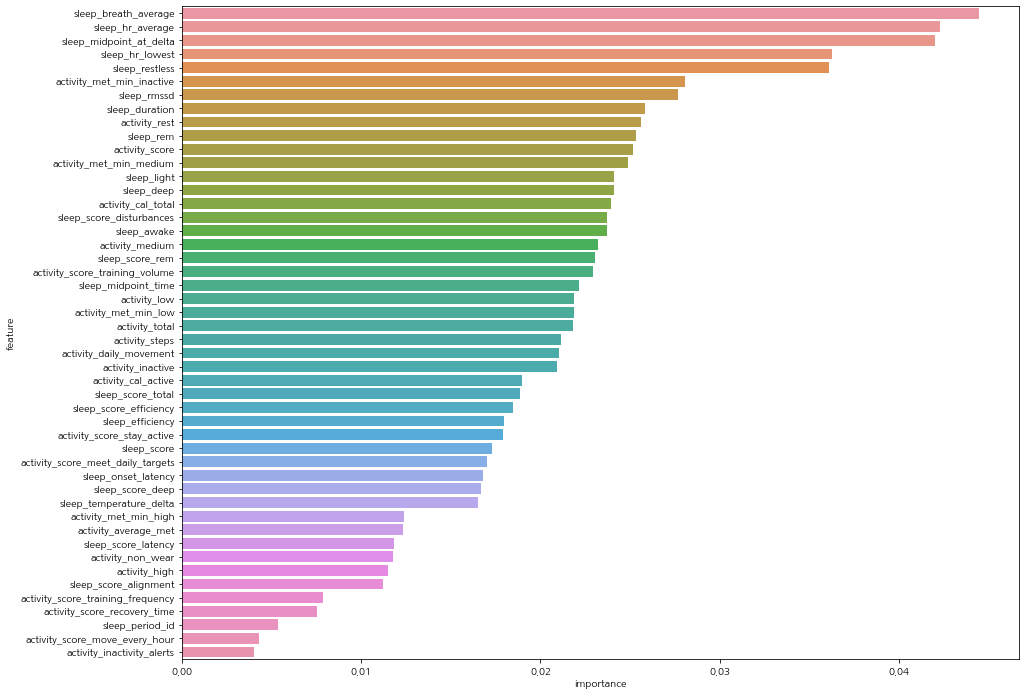

In [23]:
# RF, DT의 feature importance 는 Gini Impurity 기반의 것만 제공합니다 
feature_importance = pd.DataFrame(test_X.columns, columns=["feature"])
feature_importance["importance"] = model_rf.feature_importances_
feature_importance = feature_importance.sort_values(by=["importance"], ascending=False)

plt.figure(figsize = (15,12))
sns.barplot(data=feature_importance, x="importance", y="feature")

### XGB

In [24]:
model_xgb = XGBClassifier(
    eval_metric='mlogloss', use_label_encoder=False )

In [25]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X.iloc[train_index], input_data_X.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_xgb.fit(x_train, y_train)
    pred = model_xgb.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.4796,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]

#2 교차 검증 정확도 : 0.6193,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]

#3 교차 검증 정확도 : 0.5181,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]

#4 교차 검증 정확도 : 0.5536,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]

#5 교차 검증 정확도 : 0.5228,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.53868


In [26]:
pred_xgb_prob = model_xgb.predict_proba(test_X)
pred_xgb = np.argmax(pred_xgb_prob, axis=1)

print(classification_report(test_y, pred_xgb))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1194
           1       0.87      0.85      0.86       129
           2       0.86      0.73      0.79       543

    accuracy                           0.87      1866
   macro avg       0.87      0.84      0.85      1866
weighted avg       0.87      0.87      0.87      1866



<AxesSubplot:xlabel='importance', ylabel='feature'>

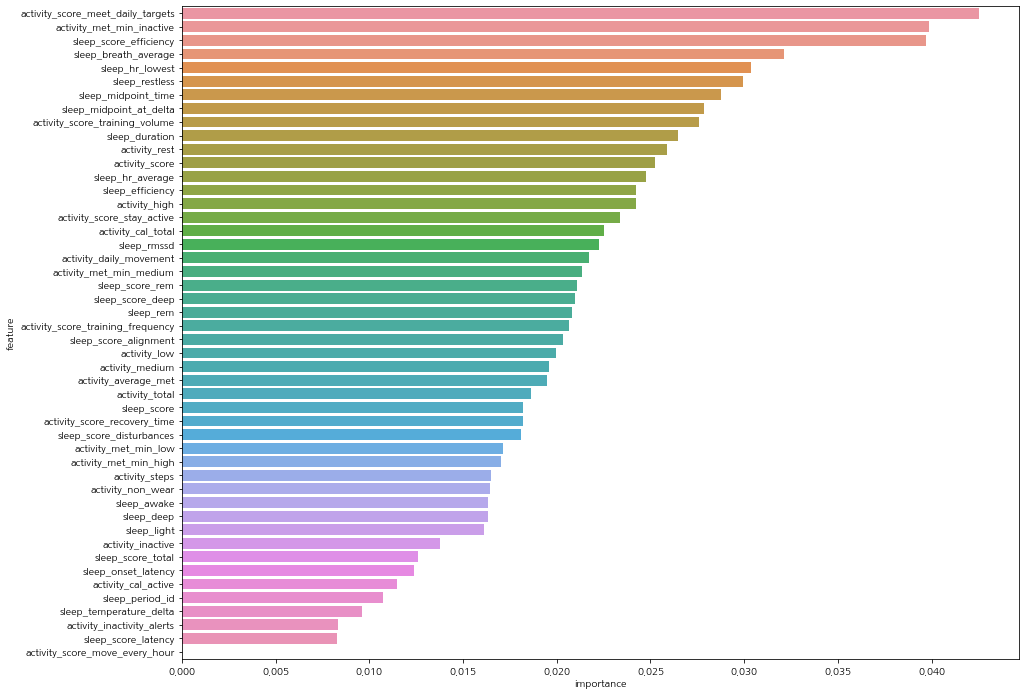

In [30]:
# XGB, LGBM과 같은 Gradient Boosting 계열의 모델은 feature importance를 계산하는 여러가지 option이 존재
# default 는 gain/total gain 
# gain/total gain : featur가 모델 예측에 어느정도 영향을 미쳤는가를 측정하는 방법
# 특정 feature로 분기되었을 때 얻는 성능 상의 이득을 계산 (gini impurity와 비슷)
# 이밖의 option -> cover/total cover, weight 
# 자세한 것은 https://hongl.tistory.com/131
feature_importance = pd.DataFrame(test_X.columns, columns=["feature"])
feature_importance["importance"] = model_xgb.feature_importances_
feature_importance = feature_importance.sort_values(by=["importance"], ascending=False)

plt.figure(figsize = (15,12))
sns.barplot(data=feature_importance, x="importance", y="feature")

### LGBM

In [27]:
model_lgbm = LGBMClassifier()

In [28]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X.iloc[train_index], input_data_X.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_lgbm.fit(x_train, y_train)
    pred = model_lgbm.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.4776,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]

#2 교차 검증 정확도 : 0.6448,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]

#3 교차 검증 정확도 : 0.5349,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]

#4 교차 검증 정확도 : 0.5436,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]

#5 교차 검증 정확도 : 0.5295,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.5460800000000001


In [29]:
pred_lgbm_prob = model_lgbm.predict_proba(test_X)
pred_lgbm = np.argmax(pred_lgbm_prob, axis=1)

print(classification_report(test_y, pred_lgbm))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1194
           1       0.89      0.87      0.88       129
           2       0.86      0.73      0.79       543

    accuracy                           0.87      1866
   macro avg       0.87      0.84      0.86      1866
weighted avg       0.87      0.87      0.87      1866



<AxesSubplot:xlabel='importance', ylabel='feature'>

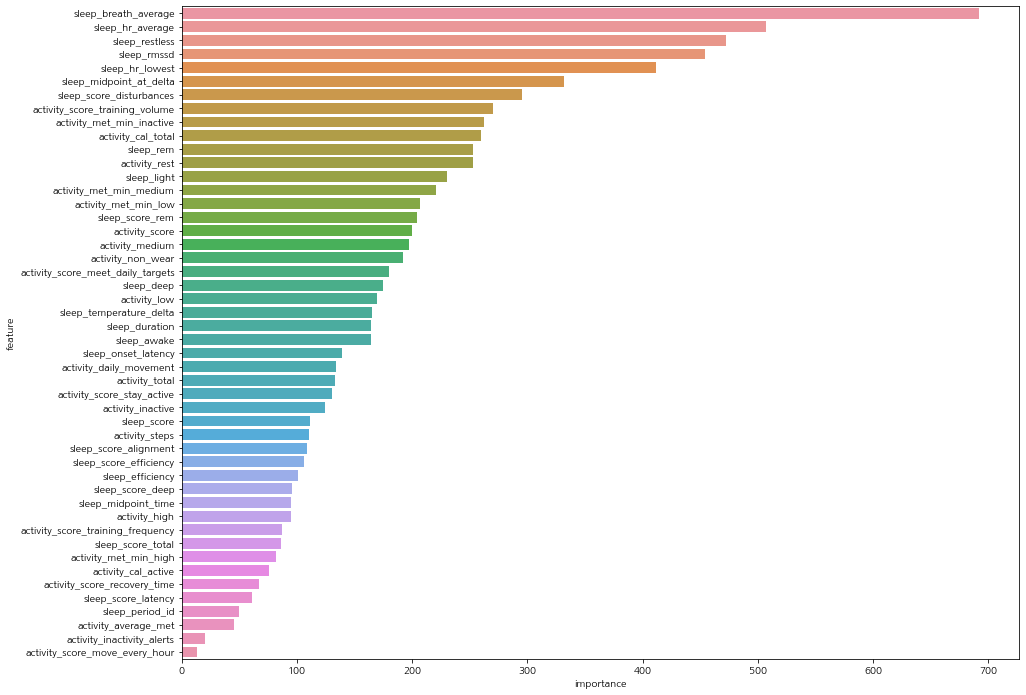

In [31]:
feature_importance = pd.DataFrame(test_X.columns, columns=["feature"])
feature_importance["importance"] = model_lgbm.feature_importances_
feature_importance = feature_importance.sort_values(by=["importance"], ascending=False)

plt.figure(figsize = (15,12))
sns.barplot(data=feature_importance, x="importance", y="feature")

### CatBoost

In [34]:
# Categorical 범주에 적잡한 알고리즘 
# 수치형 변수가 많다면 lightGBM보다 학습 속도가느릴 수 있음 
model_cat = CatBoostClassifier()

In [35]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X.iloc[train_index], input_data_X.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_cat.fit(x_train, y_train)
    pred = model_cat.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))

Learning rate set to 0.086674
0:	learn: 1.0507875	total: 148ms	remaining: 2m 27s
1:	learn: 1.0120067	total: 160ms	remaining: 1m 19s
2:	learn: 0.9757200	total: 172ms	remaining: 57s
3:	learn: 0.9452100	total: 186ms	remaining: 46.2s
4:	learn: 0.9175665	total: 199ms	remaining: 39.5s
5:	learn: 0.8932527	total: 210ms	remaining: 34.7s
6:	learn: 0.8738848	total: 221ms	remaining: 31.3s
7:	learn: 0.8537387	total: 231ms	remaining: 28.6s
8:	learn: 0.8351611	total: 241ms	remaining: 26.6s
9:	learn: 0.8181381	total: 254ms	remaining: 25.1s
10:	learn: 0.8018156	total: 265ms	remaining: 23.8s
11:	learn: 0.7888478	total: 275ms	remaining: 22.6s
12:	learn: 0.7765993	total: 286ms	remaining: 21.7s
13:	learn: 0.7644760	total: 297ms	remaining: 20.9s
14:	learn: 0.7564929	total: 308ms	remaining: 20.2s
15:	learn: 0.7459093	total: 320ms	remaining: 19.7s
16:	learn: 0.7368455	total: 330ms	remaining: 19.1s
17:	learn: 0.7261270	total: 340ms	remaining: 18.6s
18:	learn: 0.7178481	total: 352ms	remaining: 18.2s
19:	learn: 

161:	learn: 0.3535407	total: 1.98s	remaining: 10.2s
162:	learn: 0.3520244	total: 1.99s	remaining: 10.2s
163:	learn: 0.3504206	total: 2s	remaining: 10.2s
164:	learn: 0.3495611	total: 2.01s	remaining: 10.2s
165:	learn: 0.3483938	total: 2.02s	remaining: 10.2s
166:	learn: 0.3470292	total: 2.04s	remaining: 10.2s
167:	learn: 0.3459730	total: 2.05s	remaining: 10.2s
168:	learn: 0.3442999	total: 2.06s	remaining: 10.1s
169:	learn: 0.3431858	total: 2.07s	remaining: 10.1s
170:	learn: 0.3422828	total: 2.08s	remaining: 10.1s
171:	learn: 0.3402830	total: 2.09s	remaining: 10.1s
172:	learn: 0.3395476	total: 2.11s	remaining: 10.1s
173:	learn: 0.3384492	total: 2.12s	remaining: 10s
174:	learn: 0.3375206	total: 2.13s	remaining: 10s
175:	learn: 0.3368017	total: 2.14s	remaining: 10s
176:	learn: 0.3352265	total: 2.15s	remaining: 9.99s
177:	learn: 0.3333464	total: 2.16s	remaining: 9.98s
178:	learn: 0.3324499	total: 2.17s	remaining: 9.97s
179:	learn: 0.3312028	total: 2.18s	remaining: 9.95s
180:	learn: 0.3302624

325:	learn: 0.2281509	total: 3.92s	remaining: 8.12s
326:	learn: 0.2278714	total: 3.94s	remaining: 8.11s
327:	learn: 0.2276285	total: 3.95s	remaining: 8.09s
328:	learn: 0.2267128	total: 3.96s	remaining: 8.08s
329:	learn: 0.2259694	total: 3.97s	remaining: 8.07s
330:	learn: 0.2256351	total: 3.98s	remaining: 8.05s
331:	learn: 0.2254049	total: 4s	remaining: 8.04s
332:	learn: 0.2249880	total: 4.01s	remaining: 8.03s
333:	learn: 0.2246998	total: 4.02s	remaining: 8.02s
334:	learn: 0.2240785	total: 4.03s	remaining: 8.01s
335:	learn: 0.2234821	total: 4.04s	remaining: 7.99s
336:	learn: 0.2230813	total: 4.06s	remaining: 7.98s
337:	learn: 0.2226362	total: 4.07s	remaining: 7.97s
338:	learn: 0.2224844	total: 4.08s	remaining: 7.96s
339:	learn: 0.2220813	total: 4.09s	remaining: 7.95s
340:	learn: 0.2214039	total: 4.11s	remaining: 7.93s
341:	learn: 0.2206780	total: 4.12s	remaining: 7.92s
342:	learn: 0.2202972	total: 4.13s	remaining: 7.91s
343:	learn: 0.2194078	total: 4.14s	remaining: 7.9s
344:	learn: 0.21

496:	learn: 0.1626911	total: 5.89s	remaining: 5.96s
497:	learn: 0.1624974	total: 5.9s	remaining: 5.95s
498:	learn: 0.1622978	total: 5.91s	remaining: 5.93s
499:	learn: 0.1619305	total: 5.92s	remaining: 5.92s
500:	learn: 0.1615039	total: 5.93s	remaining: 5.91s
501:	learn: 0.1612629	total: 5.94s	remaining: 5.89s
502:	learn: 0.1609478	total: 5.95s	remaining: 5.88s
503:	learn: 0.1606312	total: 5.96s	remaining: 5.87s
504:	learn: 0.1602822	total: 5.98s	remaining: 5.86s
505:	learn: 0.1599812	total: 5.99s	remaining: 5.84s
506:	learn: 0.1595700	total: 6s	remaining: 5.83s
507:	learn: 0.1593189	total: 6.01s	remaining: 5.82s
508:	learn: 0.1591370	total: 6.02s	remaining: 5.8s
509:	learn: 0.1589197	total: 6.03s	remaining: 5.79s
510:	learn: 0.1587397	total: 6.04s	remaining: 5.78s
511:	learn: 0.1584898	total: 6.05s	remaining: 5.77s
512:	learn: 0.1580626	total: 6.06s	remaining: 5.76s
513:	learn: 0.1579107	total: 6.08s	remaining: 5.75s
514:	learn: 0.1575696	total: 6.09s	remaining: 5.74s
515:	learn: 0.157

663:	learn: 0.1240155	total: 7.86s	remaining: 3.98s
664:	learn: 0.1238935	total: 7.87s	remaining: 3.96s
665:	learn: 0.1237943	total: 7.88s	remaining: 3.95s
666:	learn: 0.1235654	total: 7.89s	remaining: 3.94s
667:	learn: 0.1234108	total: 7.91s	remaining: 3.93s
668:	learn: 0.1232825	total: 7.92s	remaining: 3.92s
669:	learn: 0.1231344	total: 7.93s	remaining: 3.9s
670:	learn: 0.1227107	total: 7.94s	remaining: 3.89s
671:	learn: 0.1225719	total: 7.95s	remaining: 3.88s
672:	learn: 0.1224455	total: 7.96s	remaining: 3.87s
673:	learn: 0.1221835	total: 7.98s	remaining: 3.86s
674:	learn: 0.1220353	total: 7.99s	remaining: 3.85s
675:	learn: 0.1219351	total: 8s	remaining: 3.83s
676:	learn: 0.1217619	total: 8.01s	remaining: 3.82s
677:	learn: 0.1216291	total: 8.02s	remaining: 3.81s
678:	learn: 0.1214062	total: 8.03s	remaining: 3.8s
679:	learn: 0.1212269	total: 8.05s	remaining: 3.79s
680:	learn: 0.1210843	total: 8.07s	remaining: 3.78s
681:	learn: 0.1209081	total: 8.08s	remaining: 3.77s
682:	learn: 0.120

826:	learn: 0.0976684	total: 9.8s	remaining: 2.05s
827:	learn: 0.0975464	total: 9.82s	remaining: 2.04s
828:	learn: 0.0974616	total: 9.83s	remaining: 2.03s
829:	learn: 0.0973756	total: 9.84s	remaining: 2.02s
830:	learn: 0.0971833	total: 9.85s	remaining: 2s
831:	learn: 0.0970996	total: 9.86s	remaining: 1.99s
832:	learn: 0.0969829	total: 9.87s	remaining: 1.98s
833:	learn: 0.0969248	total: 9.88s	remaining: 1.97s
834:	learn: 0.0967646	total: 9.9s	remaining: 1.96s
835:	learn: 0.0966779	total: 9.91s	remaining: 1.94s
836:	learn: 0.0965380	total: 9.92s	remaining: 1.93s
837:	learn: 0.0964267	total: 9.93s	remaining: 1.92s
838:	learn: 0.0962628	total: 9.94s	remaining: 1.91s
839:	learn: 0.0960916	total: 9.95s	remaining: 1.9s
840:	learn: 0.0959892	total: 9.96s	remaining: 1.88s
841:	learn: 0.0958148	total: 9.97s	remaining: 1.87s
842:	learn: 0.0956911	total: 9.98s	remaining: 1.86s
843:	learn: 0.0956208	total: 10s	remaining: 1.85s
844:	learn: 0.0954037	total: 10s	remaining: 1.84s
845:	learn: 0.0952609	

999:	learn: 0.0775683	total: 11.8s	remaining: 0us

#1 교차 검증 정확도 : 0.4776,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]
Learning rate set to 0.086675
0:	learn: 1.0572413	total: 56.2ms	remaining: 56.2s
1:	learn: 1.0207846	total: 83.3ms	remaining: 41.5s
2:	learn: 0.9882655	total: 101ms	remaining: 33.5s
3:	learn: 0.9588894	total: 114ms	remaining: 28.5s
4:	learn: 0.9339698	total: 125ms	remaining: 24.8s
5:	learn: 0.9121008	total: 136ms	remaining: 22.5s
6:	learn: 0.8910482	total: 146ms	remaining: 20.8s
7:	learn: 0.8724464	total: 157ms	remaining: 19.5s
8:	learn: 0.8554413	total: 168ms	remaining: 18.5s
9:	learn: 0.8379067	total: 179ms	remaining: 17.7s
10:	learn: 0.8216732	total: 189ms	remaining: 17s
11:	learn: 0.8087433	total: 200ms	remaining: 16.5s
12:	learn: 0.7975623	total: 210ms	remaining: 15.9s
13:	learn: 0.7853418	total: 221ms	remaining: 15.6s
14:	learn: 0.7761563	total: 234ms	remaining: 15.4s
15:	learn: 0.7652732	total: 244ms	remaining: 15s
16:	

159:	learn: 0.3669765	total: 1.9s	remaining: 9.96s
160:	learn: 0.3661491	total: 1.91s	remaining: 9.94s
161:	learn: 0.3638271	total: 1.92s	remaining: 9.92s
162:	learn: 0.3618689	total: 1.93s	remaining: 9.9s
163:	learn: 0.3613204	total: 1.94s	remaining: 9.89s
164:	learn: 0.3600682	total: 1.95s	remaining: 9.88s
165:	learn: 0.3586830	total: 1.96s	remaining: 9.86s
166:	learn: 0.3575900	total: 1.97s	remaining: 9.85s
167:	learn: 0.3558856	total: 1.99s	remaining: 9.83s
168:	learn: 0.3551465	total: 2s	remaining: 9.81s
169:	learn: 0.3543067	total: 2.01s	remaining: 9.8s
170:	learn: 0.3534186	total: 2.02s	remaining: 9.79s
171:	learn: 0.3525339	total: 2.03s	remaining: 9.77s
172:	learn: 0.3514399	total: 2.04s	remaining: 9.76s
173:	learn: 0.3506710	total: 2.05s	remaining: 9.75s
174:	learn: 0.3499629	total: 2.07s	remaining: 9.75s
175:	learn: 0.3489745	total: 2.08s	remaining: 9.73s
176:	learn: 0.3482342	total: 2.09s	remaining: 9.73s
177:	learn: 0.3468628	total: 2.1s	remaining: 9.72s
178:	learn: 0.34598

321:	learn: 0.2418470	total: 3.86s	remaining: 8.13s
322:	learn: 0.2413709	total: 3.88s	remaining: 8.12s
323:	learn: 0.2410666	total: 3.89s	remaining: 8.12s
324:	learn: 0.2407445	total: 3.9s	remaining: 8.11s
325:	learn: 0.2402618	total: 3.92s	remaining: 8.1s
326:	learn: 0.2396297	total: 3.93s	remaining: 8.09s
327:	learn: 0.2387858	total: 3.94s	remaining: 8.08s
328:	learn: 0.2383338	total: 3.96s	remaining: 8.07s
329:	learn: 0.2373556	total: 3.97s	remaining: 8.07s
330:	learn: 0.2368143	total: 3.99s	remaining: 8.06s
331:	learn: 0.2363219	total: 4.01s	remaining: 8.06s
332:	learn: 0.2360110	total: 4.02s	remaining: 8.05s
333:	learn: 0.2357124	total: 4.03s	remaining: 8.04s
334:	learn: 0.2352012	total: 4.04s	remaining: 8.03s
335:	learn: 0.2349143	total: 4.06s	remaining: 8.02s
336:	learn: 0.2343317	total: 4.07s	remaining: 8.02s
337:	learn: 0.2339376	total: 4.09s	remaining: 8.01s
338:	learn: 0.2334093	total: 4.1s	remaining: 7.99s
339:	learn: 0.2331482	total: 4.11s	remaining: 7.98s
340:	learn: 0.2

482:	learn: 0.1798014	total: 5.85s	remaining: 6.26s
483:	learn: 0.1795032	total: 5.86s	remaining: 6.25s
484:	learn: 0.1790819	total: 5.87s	remaining: 6.24s
485:	learn: 0.1788462	total: 5.88s	remaining: 6.22s
486:	learn: 0.1785999	total: 5.9s	remaining: 6.21s
487:	learn: 0.1781768	total: 5.91s	remaining: 6.2s
488:	learn: 0.1779829	total: 5.92s	remaining: 6.19s
489:	learn: 0.1775844	total: 5.93s	remaining: 6.18s
490:	learn: 0.1771859	total: 5.95s	remaining: 6.17s
491:	learn: 0.1769192	total: 5.96s	remaining: 6.16s
492:	learn: 0.1765435	total: 5.97s	remaining: 6.14s
493:	learn: 0.1762307	total: 5.98s	remaining: 6.13s
494:	learn: 0.1758241	total: 6s	remaining: 6.12s
495:	learn: 0.1755543	total: 6.01s	remaining: 6.11s
496:	learn: 0.1754641	total: 6.02s	remaining: 6.1s
497:	learn: 0.1746889	total: 6.04s	remaining: 6.08s
498:	learn: 0.1744700	total: 6.05s	remaining: 6.07s
499:	learn: 0.1741916	total: 6.06s	remaining: 6.06s
500:	learn: 0.1738621	total: 6.07s	remaining: 6.05s
501:	learn: 0.1737

643:	learn: 0.1383573	total: 7.8s	remaining: 4.31s
644:	learn: 0.1382396	total: 7.82s	remaining: 4.3s
645:	learn: 0.1380020	total: 7.83s	remaining: 4.29s
646:	learn: 0.1378407	total: 7.84s	remaining: 4.28s
647:	learn: 0.1376361	total: 7.86s	remaining: 4.27s
648:	learn: 0.1374463	total: 7.87s	remaining: 4.26s
649:	learn: 0.1373183	total: 7.88s	remaining: 4.24s
650:	learn: 0.1370316	total: 7.89s	remaining: 4.23s
651:	learn: 0.1367816	total: 7.91s	remaining: 4.22s
652:	learn: 0.1366638	total: 7.92s	remaining: 4.21s
653:	learn: 0.1365907	total: 7.93s	remaining: 4.19s
654:	learn: 0.1364944	total: 7.94s	remaining: 4.18s
655:	learn: 0.1360844	total: 7.95s	remaining: 4.17s
656:	learn: 0.1360038	total: 7.97s	remaining: 4.16s
657:	learn: 0.1356900	total: 7.98s	remaining: 4.15s
658:	learn: 0.1355781	total: 7.99s	remaining: 4.13s
659:	learn: 0.1352935	total: 8.01s	remaining: 4.12s
660:	learn: 0.1351365	total: 8.02s	remaining: 4.11s
661:	learn: 0.1349332	total: 8.03s	remaining: 4.1s
662:	learn: 0.1

806:	learn: 0.1098514	total: 9.75s	remaining: 2.33s
807:	learn: 0.1096522	total: 9.77s	remaining: 2.32s
808:	learn: 0.1094068	total: 9.78s	remaining: 2.31s
809:	learn: 0.1091748	total: 9.79s	remaining: 2.3s
810:	learn: 0.1089088	total: 9.8s	remaining: 2.28s
811:	learn: 0.1087576	total: 9.81s	remaining: 2.27s
812:	learn: 0.1086230	total: 9.82s	remaining: 2.26s
813:	learn: 0.1084856	total: 9.83s	remaining: 2.25s
814:	learn: 0.1082781	total: 9.84s	remaining: 2.23s
815:	learn: 0.1081384	total: 9.86s	remaining: 2.22s
816:	learn: 0.1080776	total: 9.87s	remaining: 2.21s
817:	learn: 0.1077936	total: 9.88s	remaining: 2.2s
818:	learn: 0.1076433	total: 9.89s	remaining: 2.19s
819:	learn: 0.1075163	total: 9.9s	remaining: 2.17s
820:	learn: 0.1073048	total: 9.92s	remaining: 2.16s
821:	learn: 0.1072327	total: 9.93s	remaining: 2.15s
822:	learn: 0.1071692	total: 9.94s	remaining: 2.14s
823:	learn: 0.1071045	total: 9.95s	remaining: 2.13s
824:	learn: 0.1068392	total: 9.96s	remaining: 2.11s
825:	learn: 0.10

972:	learn: 0.0882075	total: 11.7s	remaining: 325ms
973:	learn: 0.0881071	total: 11.7s	remaining: 313ms
974:	learn: 0.0880536	total: 11.7s	remaining: 301ms
975:	learn: 0.0880265	total: 11.8s	remaining: 289ms
976:	learn: 0.0879530	total: 11.8s	remaining: 277ms
977:	learn: 0.0879206	total: 11.8s	remaining: 265ms
978:	learn: 0.0878817	total: 11.8s	remaining: 253ms
979:	learn: 0.0877495	total: 11.8s	remaining: 241ms
980:	learn: 0.0876482	total: 11.8s	remaining: 229ms
981:	learn: 0.0876124	total: 11.8s	remaining: 217ms
982:	learn: 0.0874993	total: 11.8s	remaining: 205ms
983:	learn: 0.0874021	total: 11.8s	remaining: 193ms
984:	learn: 0.0872804	total: 11.9s	remaining: 181ms
985:	learn: 0.0872205	total: 11.9s	remaining: 168ms
986:	learn: 0.0869901	total: 11.9s	remaining: 156ms
987:	learn: 0.0868167	total: 11.9s	remaining: 144ms
988:	learn: 0.0865513	total: 11.9s	remaining: 132ms
989:	learn: 0.0864438	total: 11.9s	remaining: 120ms
990:	learn: 0.0862597	total: 11.9s	remaining: 108ms
991:	learn: 

132:	learn: 0.3783677	total: 1.54s	remaining: 10s
133:	learn: 0.3765167	total: 1.55s	remaining: 10s
134:	learn: 0.3754065	total: 1.56s	remaining: 10s
135:	learn: 0.3733067	total: 1.57s	remaining: 9.99s
136:	learn: 0.3713405	total: 1.58s	remaining: 9.97s
137:	learn: 0.3693614	total: 1.59s	remaining: 9.97s
138:	learn: 0.3679199	total: 1.61s	remaining: 9.95s
139:	learn: 0.3666336	total: 1.62s	remaining: 9.93s
140:	learn: 0.3656869	total: 1.63s	remaining: 9.91s
141:	learn: 0.3641879	total: 1.64s	remaining: 9.9s
142:	learn: 0.3626195	total: 1.65s	remaining: 9.89s
143:	learn: 0.3608840	total: 1.66s	remaining: 9.87s
144:	learn: 0.3596467	total: 1.67s	remaining: 9.85s
145:	learn: 0.3575450	total: 1.68s	remaining: 9.82s
146:	learn: 0.3555411	total: 1.69s	remaining: 9.81s
147:	learn: 0.3536130	total: 1.7s	remaining: 9.81s
148:	learn: 0.3518830	total: 1.72s	remaining: 9.8s
149:	learn: 0.3500913	total: 1.73s	remaining: 9.8s
150:	learn: 0.3490883	total: 1.74s	remaining: 9.79s
151:	learn: 0.3471114	

306:	learn: 0.2270695	total: 3.52s	remaining: 7.94s
307:	learn: 0.2265500	total: 3.53s	remaining: 7.93s
308:	learn: 0.2256991	total: 3.54s	remaining: 7.92s
309:	learn: 0.2247950	total: 3.55s	remaining: 7.91s
310:	learn: 0.2244709	total: 3.56s	remaining: 7.89s
311:	learn: 0.2240910	total: 3.57s	remaining: 7.88s
312:	learn: 0.2236243	total: 3.58s	remaining: 7.87s
313:	learn: 0.2232288	total: 3.59s	remaining: 7.85s
314:	learn: 0.2227663	total: 3.6s	remaining: 7.84s
315:	learn: 0.2223744	total: 3.62s	remaining: 7.83s
316:	learn: 0.2219674	total: 3.63s	remaining: 7.82s
317:	learn: 0.2215783	total: 3.64s	remaining: 7.8s
318:	learn: 0.2208845	total: 3.65s	remaining: 7.8s
319:	learn: 0.2203543	total: 3.66s	remaining: 7.79s
320:	learn: 0.2198869	total: 3.67s	remaining: 7.77s
321:	learn: 0.2196583	total: 3.68s	remaining: 7.76s
322:	learn: 0.2192216	total: 3.69s	remaining: 7.75s
323:	learn: 0.2184790	total: 3.71s	remaining: 7.73s
324:	learn: 0.2181404	total: 3.72s	remaining: 7.73s
325:	learn: 0.2

465:	learn: 0.1632553	total: 5.32s	remaining: 6.1s
466:	learn: 0.1630092	total: 5.34s	remaining: 6.09s
467:	learn: 0.1626294	total: 5.35s	remaining: 6.08s
468:	learn: 0.1622174	total: 5.36s	remaining: 6.07s
469:	learn: 0.1618736	total: 5.37s	remaining: 6.06s
470:	learn: 0.1615694	total: 5.38s	remaining: 6.05s
471:	learn: 0.1613496	total: 5.4s	remaining: 6.04s
472:	learn: 0.1609897	total: 5.41s	remaining: 6.03s
473:	learn: 0.1604745	total: 5.42s	remaining: 6.02s
474:	learn: 0.1600726	total: 5.43s	remaining: 6.01s
475:	learn: 0.1598554	total: 5.45s	remaining: 6s
476:	learn: 0.1594677	total: 5.46s	remaining: 5.99s
477:	learn: 0.1590133	total: 5.47s	remaining: 5.98s
478:	learn: 0.1587463	total: 5.49s	remaining: 5.97s
479:	learn: 0.1585682	total: 5.5s	remaining: 5.96s
480:	learn: 0.1582602	total: 5.51s	remaining: 5.94s
481:	learn: 0.1580979	total: 5.52s	remaining: 5.94s
482:	learn: 0.1577520	total: 5.54s	remaining: 5.93s
483:	learn: 0.1575355	total: 5.55s	remaining: 5.92s
484:	learn: 0.1572

637:	learn: 0.1211291	total: 7.29s	remaining: 4.14s
638:	learn: 0.1210390	total: 7.3s	remaining: 4.13s
639:	learn: 0.1208690	total: 7.31s	remaining: 4.11s
640:	learn: 0.1206551	total: 7.33s	remaining: 4.1s
641:	learn: 0.1204320	total: 7.34s	remaining: 4.09s
642:	learn: 0.1201906	total: 7.35s	remaining: 4.08s
643:	learn: 0.1200227	total: 7.36s	remaining: 4.07s
644:	learn: 0.1198265	total: 7.37s	remaining: 4.05s
645:	learn: 0.1196518	total: 7.38s	remaining: 4.04s
646:	learn: 0.1194649	total: 7.39s	remaining: 4.03s
647:	learn: 0.1192576	total: 7.4s	remaining: 4.02s
648:	learn: 0.1190543	total: 7.41s	remaining: 4.01s
649:	learn: 0.1189000	total: 7.42s	remaining: 4s
650:	learn: 0.1187345	total: 7.43s	remaining: 3.98s
651:	learn: 0.1185784	total: 7.44s	remaining: 3.97s
652:	learn: 0.1184158	total: 7.46s	remaining: 3.96s
653:	learn: 0.1182287	total: 7.47s	remaining: 3.95s
654:	learn: 0.1181040	total: 7.48s	remaining: 3.94s
655:	learn: 0.1178437	total: 7.49s	remaining: 3.93s
656:	learn: 0.1176

813:	learn: 0.0930986	total: 9.29s	remaining: 2.12s
814:	learn: 0.0930421	total: 9.3s	remaining: 2.11s
815:	learn: 0.0927926	total: 9.31s	remaining: 2.1s
816:	learn: 0.0926335	total: 9.33s	remaining: 2.09s
817:	learn: 0.0925556	total: 9.34s	remaining: 2.08s
818:	learn: 0.0923985	total: 9.35s	remaining: 2.07s
819:	learn: 0.0923303	total: 9.36s	remaining: 2.05s
820:	learn: 0.0922238	total: 9.37s	remaining: 2.04s
821:	learn: 0.0921214	total: 9.38s	remaining: 2.03s
822:	learn: 0.0919788	total: 9.39s	remaining: 2.02s
823:	learn: 0.0918700	total: 9.41s	remaining: 2.01s
824:	learn: 0.0917708	total: 9.42s	remaining: 2s
825:	learn: 0.0916430	total: 9.43s	remaining: 1.99s
826:	learn: 0.0914984	total: 9.44s	remaining: 1.98s
827:	learn: 0.0914536	total: 9.45s	remaining: 1.96s
828:	learn: 0.0913538	total: 9.46s	remaining: 1.95s
829:	learn: 0.0912925	total: 9.48s	remaining: 1.94s
830:	learn: 0.0909899	total: 9.49s	remaining: 1.93s
831:	learn: 0.0908762	total: 9.5s	remaining: 1.92s
832:	learn: 0.0908

987:	learn: 0.0745269	total: 11.3s	remaining: 137ms
988:	learn: 0.0744702	total: 11.3s	remaining: 126ms
989:	learn: 0.0744246	total: 11.3s	remaining: 114ms
990:	learn: 0.0743249	total: 11.3s	remaining: 103ms
991:	learn: 0.0742312	total: 11.3s	remaining: 91.3ms
992:	learn: 0.0740664	total: 11.3s	remaining: 79.9ms
993:	learn: 0.0739771	total: 11.3s	remaining: 68.5ms
994:	learn: 0.0738689	total: 11.4s	remaining: 57.1ms
995:	learn: 0.0737819	total: 11.4s	remaining: 45.6ms
996:	learn: 0.0736446	total: 11.4s	remaining: 34.2ms
997:	learn: 0.0735503	total: 11.4s	remaining: 22.8ms
998:	learn: 0.0733973	total: 11.4s	remaining: 11.4ms
999:	learn: 0.0732964	total: 11.4s	remaining: 0us

#3 교차 검증 정확도 : 0.5355,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]
Learning rate set to 0.086675
0:	learn: 1.0564283	total: 27.6ms	remaining: 27.6s
1:	learn: 1.0160313	total: 49.6ms	remaining: 24.8s
2:	learn: 0.9807252	total: 65.4ms	remaining: 21.7s
3:	learn: 0.9466303	tot

159:	learn: 0.3646775	total: 1.87s	remaining: 9.83s
160:	learn: 0.3639223	total: 1.88s	remaining: 9.82s
161:	learn: 0.3627090	total: 1.9s	remaining: 9.81s
162:	learn: 0.3616268	total: 1.91s	remaining: 9.79s
163:	learn: 0.3600297	total: 1.92s	remaining: 9.78s
164:	learn: 0.3587595	total: 1.93s	remaining: 9.77s
165:	learn: 0.3572575	total: 1.94s	remaining: 9.75s
166:	learn: 0.3555859	total: 1.95s	remaining: 9.73s
167:	learn: 0.3539448	total: 1.96s	remaining: 9.72s
168:	learn: 0.3529930	total: 1.97s	remaining: 9.7s
169:	learn: 0.3525319	total: 1.98s	remaining: 9.68s
170:	learn: 0.3512938	total: 2s	remaining: 9.67s
171:	learn: 0.3502360	total: 2s	remaining: 9.65s
172:	learn: 0.3495746	total: 2.02s	remaining: 9.65s
173:	learn: 0.3480870	total: 2.03s	remaining: 9.64s
174:	learn: 0.3472719	total: 2.04s	remaining: 9.62s
175:	learn: 0.3463778	total: 2.06s	remaining: 9.62s
176:	learn: 0.3453510	total: 2.07s	remaining: 9.63s
177:	learn: 0.3446243	total: 2.08s	remaining: 9.61s
178:	learn: 0.343064

329:	learn: 0.2363324	total: 3.83s	remaining: 7.79s
330:	learn: 0.2354518	total: 3.85s	remaining: 7.78s
331:	learn: 0.2350742	total: 3.86s	remaining: 7.76s
332:	learn: 0.2346202	total: 3.87s	remaining: 7.75s
333:	learn: 0.2338636	total: 3.88s	remaining: 7.74s
334:	learn: 0.2329834	total: 3.89s	remaining: 7.73s
335:	learn: 0.2321685	total: 3.9s	remaining: 7.71s
336:	learn: 0.2312103	total: 3.92s	remaining: 7.7s
337:	learn: 0.2307699	total: 3.93s	remaining: 7.69s
338:	learn: 0.2297477	total: 3.94s	remaining: 7.68s
339:	learn: 0.2291548	total: 3.95s	remaining: 7.67s
340:	learn: 0.2288321	total: 3.96s	remaining: 7.65s
341:	learn: 0.2281937	total: 3.97s	remaining: 7.64s
342:	learn: 0.2278684	total: 3.98s	remaining: 7.63s
343:	learn: 0.2270764	total: 3.99s	remaining: 7.62s
344:	learn: 0.2266353	total: 4.01s	remaining: 7.61s
345:	learn: 0.2259022	total: 4.02s	remaining: 7.59s
346:	learn: 0.2253761	total: 4.03s	remaining: 7.58s
347:	learn: 0.2246854	total: 4.04s	remaining: 7.58s
348:	learn: 0.

499:	learn: 0.1697726	total: 5.79s	remaining: 5.79s
500:	learn: 0.1693560	total: 5.8s	remaining: 5.78s
501:	learn: 0.1691893	total: 5.81s	remaining: 5.76s
502:	learn: 0.1690029	total: 5.82s	remaining: 5.75s
503:	learn: 0.1684261	total: 5.83s	remaining: 5.74s
504:	learn: 0.1679685	total: 5.84s	remaining: 5.72s
505:	learn: 0.1677056	total: 5.85s	remaining: 5.71s
506:	learn: 0.1675449	total: 5.86s	remaining: 5.7s
507:	learn: 0.1673117	total: 5.87s	remaining: 5.69s
508:	learn: 0.1670526	total: 5.88s	remaining: 5.68s
509:	learn: 0.1668796	total: 5.89s	remaining: 5.66s
510:	learn: 0.1666278	total: 5.9s	remaining: 5.65s
511:	learn: 0.1661695	total: 5.92s	remaining: 5.64s
512:	learn: 0.1659272	total: 5.93s	remaining: 5.63s
513:	learn: 0.1653886	total: 5.93s	remaining: 5.61s
514:	learn: 0.1652137	total: 5.95s	remaining: 5.6s
515:	learn: 0.1650198	total: 5.96s	remaining: 5.59s
516:	learn: 0.1647220	total: 5.98s	remaining: 5.58s
517:	learn: 0.1643778	total: 6s	remaining: 5.58s
518:	learn: 0.16426

673:	learn: 0.1298643	total: 7.76s	remaining: 3.75s
674:	learn: 0.1295793	total: 7.77s	remaining: 3.74s
675:	learn: 0.1293490	total: 7.79s	remaining: 3.73s
676:	learn: 0.1292153	total: 7.8s	remaining: 3.72s
677:	learn: 0.1290627	total: 7.81s	remaining: 3.71s
678:	learn: 0.1289005	total: 7.82s	remaining: 3.7s
679:	learn: 0.1285836	total: 7.83s	remaining: 3.68s
680:	learn: 0.1283950	total: 7.84s	remaining: 3.67s
681:	learn: 0.1281969	total: 7.85s	remaining: 3.66s
682:	learn: 0.1281169	total: 7.86s	remaining: 3.65s
683:	learn: 0.1280076	total: 7.88s	remaining: 3.64s
684:	learn: 0.1277905	total: 7.89s	remaining: 3.63s
685:	learn: 0.1275810	total: 7.9s	remaining: 3.62s
686:	learn: 0.1274275	total: 7.91s	remaining: 3.6s
687:	learn: 0.1272432	total: 7.92s	remaining: 3.59s
688:	learn: 0.1270981	total: 7.93s	remaining: 3.58s
689:	learn: 0.1268842	total: 7.95s	remaining: 3.57s
690:	learn: 0.1267424	total: 7.96s	remaining: 3.56s
691:	learn: 0.1264887	total: 7.97s	remaining: 3.55s
692:	learn: 0.12

836:	learn: 0.1026925	total: 9.71s	remaining: 1.89s
837:	learn: 0.1025455	total: 9.72s	remaining: 1.88s
838:	learn: 0.1023179	total: 9.74s	remaining: 1.87s
839:	learn: 0.1020312	total: 9.75s	remaining: 1.86s
840:	learn: 0.1019102	total: 9.76s	remaining: 1.84s
841:	learn: 0.1016350	total: 9.78s	remaining: 1.83s
842:	learn: 0.1015396	total: 9.8s	remaining: 1.82s
843:	learn: 0.1013810	total: 9.81s	remaining: 1.81s
844:	learn: 0.1012800	total: 9.82s	remaining: 1.8s
845:	learn: 0.1011194	total: 9.84s	remaining: 1.79s
846:	learn: 0.1010383	total: 9.85s	remaining: 1.78s
847:	learn: 0.1009670	total: 9.86s	remaining: 1.77s
848:	learn: 0.1008002	total: 9.87s	remaining: 1.76s
849:	learn: 0.1007190	total: 9.89s	remaining: 1.74s
850:	learn: 0.1006373	total: 9.9s	remaining: 1.73s
851:	learn: 0.1004810	total: 9.91s	remaining: 1.72s
852:	learn: 0.1002758	total: 9.92s	remaining: 1.71s
853:	learn: 0.0999681	total: 9.94s	remaining: 1.7s
854:	learn: 0.0998503	total: 9.95s	remaining: 1.69s
855:	learn: 0.09


#4 교차 검증 정확도 : 0.5556,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]
Learning rate set to 0.086675
0:	learn: 1.0547894	total: 21.2ms	remaining: 21.2s
1:	learn: 1.0151300	total: 40.5ms	remaining: 20.2s
2:	learn: 0.9781711	total: 55.9ms	remaining: 18.6s
3:	learn: 0.9490457	total: 67.9ms	remaining: 16.9s
4:	learn: 0.9214146	total: 78.8ms	remaining: 15.7s
5:	learn: 0.8950391	total: 92.4ms	remaining: 15.3s
6:	learn: 0.8722793	total: 106ms	remaining: 15.1s
7:	learn: 0.8512296	total: 121ms	remaining: 15s
8:	learn: 0.8350953	total: 134ms	remaining: 14.7s
9:	learn: 0.8169256	total: 145ms	remaining: 14.4s
10:	learn: 0.7997024	total: 157ms	remaining: 14.1s
11:	learn: 0.7859119	total: 170ms	remaining: 14s
12:	learn: 0.7738378	total: 181ms	remaining: 13.8s
13:	learn: 0.7616189	total: 192ms	remaining: 13.5s
14:	learn: 0.7498767	total: 205ms	remaining: 13.5s
15:	learn: 0.7382183	total: 218ms	remaining: 13.4s
16:	learn: 0.7284509	total: 230ms	remaining: 13.3s

161:	learn: 0.3365673	total: 1.91s	remaining: 9.89s
162:	learn: 0.3357774	total: 1.92s	remaining: 9.88s
163:	learn: 0.3346291	total: 1.93s	remaining: 9.86s
164:	learn: 0.3337375	total: 1.94s	remaining: 9.84s
165:	learn: 0.3322526	total: 1.96s	remaining: 9.85s
166:	learn: 0.3309648	total: 1.98s	remaining: 9.87s
167:	learn: 0.3300448	total: 1.99s	remaining: 9.85s
168:	learn: 0.3293724	total: 2s	remaining: 9.83s
169:	learn: 0.3284966	total: 2.01s	remaining: 9.81s
170:	learn: 0.3269959	total: 2.02s	remaining: 9.79s
171:	learn: 0.3256831	total: 2.03s	remaining: 9.77s
172:	learn: 0.3248054	total: 2.04s	remaining: 9.76s
173:	learn: 0.3237882	total: 2.05s	remaining: 9.74s
174:	learn: 0.3226881	total: 2.06s	remaining: 9.73s
175:	learn: 0.3212518	total: 2.07s	remaining: 9.71s
176:	learn: 0.3202286	total: 2.08s	remaining: 9.7s
177:	learn: 0.3194216	total: 2.1s	remaining: 9.68s
178:	learn: 0.3183563	total: 2.11s	remaining: 9.68s
179:	learn: 0.3175422	total: 2.12s	remaining: 9.66s
180:	learn: 0.316

330:	learn: 0.2102031	total: 3.89s	remaining: 7.86s
331:	learn: 0.2099686	total: 3.9s	remaining: 7.84s
332:	learn: 0.2095916	total: 3.91s	remaining: 7.83s
333:	learn: 0.2088646	total: 3.92s	remaining: 7.82s
334:	learn: 0.2085009	total: 3.93s	remaining: 7.8s
335:	learn: 0.2078454	total: 3.94s	remaining: 7.79s
336:	learn: 0.2073992	total: 3.95s	remaining: 7.77s
337:	learn: 0.2067480	total: 3.96s	remaining: 7.76s
338:	learn: 0.2062638	total: 3.98s	remaining: 7.75s
339:	learn: 0.2058440	total: 3.98s	remaining: 7.74s
340:	learn: 0.2055501	total: 4s	remaining: 7.72s
341:	learn: 0.2052850	total: 4.01s	remaining: 7.72s
342:	learn: 0.2048340	total: 4.03s	remaining: 7.72s
343:	learn: 0.2045889	total: 4.04s	remaining: 7.71s
344:	learn: 0.2039627	total: 4.06s	remaining: 7.7s
345:	learn: 0.2034525	total: 4.07s	remaining: 7.69s
346:	learn: 0.2031857	total: 4.08s	remaining: 7.68s
347:	learn: 0.2024563	total: 4.1s	remaining: 7.67s
348:	learn: 0.2018602	total: 4.11s	remaining: 7.67s
349:	learn: 0.20123

491:	learn: 0.1510588	total: 5.83s	remaining: 6.01s
492:	learn: 0.1506745	total: 5.84s	remaining: 6s
493:	learn: 0.1503926	total: 5.85s	remaining: 5.99s
494:	learn: 0.1502300	total: 5.86s	remaining: 5.98s
495:	learn: 0.1499460	total: 5.88s	remaining: 5.97s
496:	learn: 0.1496620	total: 5.89s	remaining: 5.96s
497:	learn: 0.1495120	total: 5.9s	remaining: 5.95s
498:	learn: 0.1493973	total: 5.91s	remaining: 5.93s
499:	learn: 0.1490018	total: 5.92s	remaining: 5.92s
500:	learn: 0.1487067	total: 5.93s	remaining: 5.91s
501:	learn: 0.1485149	total: 5.94s	remaining: 5.89s
502:	learn: 0.1481819	total: 5.96s	remaining: 5.88s
503:	learn: 0.1480383	total: 5.97s	remaining: 5.87s
504:	learn: 0.1477236	total: 5.98s	remaining: 5.87s
505:	learn: 0.1476281	total: 6s	remaining: 5.85s
506:	learn: 0.1475554	total: 6.01s	remaining: 5.84s
507:	learn: 0.1473632	total: 6.02s	remaining: 5.83s
508:	learn: 0.1472115	total: 6.03s	remaining: 5.82s
509:	learn: 0.1468316	total: 6.04s	remaining: 5.8s
510:	learn: 0.146580

653:	learn: 0.1171821	total: 7.78s	remaining: 4.12s
654:	learn: 0.1170955	total: 7.79s	remaining: 4.1s
655:	learn: 0.1168549	total: 7.81s	remaining: 4.09s
656:	learn: 0.1166006	total: 7.82s	remaining: 4.08s
657:	learn: 0.1164746	total: 7.83s	remaining: 4.07s
658:	learn: 0.1163259	total: 7.84s	remaining: 4.06s
659:	learn: 0.1161583	total: 7.85s	remaining: 4.04s
660:	learn: 0.1160437	total: 7.86s	remaining: 4.03s
661:	learn: 0.1158697	total: 7.88s	remaining: 4.02s
662:	learn: 0.1156304	total: 7.89s	remaining: 4.01s
663:	learn: 0.1154917	total: 7.9s	remaining: 4s
664:	learn: 0.1153193	total: 7.91s	remaining: 3.98s
665:	learn: 0.1151301	total: 7.92s	remaining: 3.97s
666:	learn: 0.1148652	total: 7.93s	remaining: 3.96s
667:	learn: 0.1145818	total: 7.94s	remaining: 3.95s
668:	learn: 0.1143347	total: 7.95s	remaining: 3.94s
669:	learn: 0.1142148	total: 7.97s	remaining: 3.92s
670:	learn: 0.1140565	total: 7.98s	remaining: 3.91s
671:	learn: 0.1138496	total: 8s	remaining: 3.9s
672:	learn: 0.1137063

821:	learn: 0.0917327	total: 9.76s	remaining: 2.11s
822:	learn: 0.0916091	total: 9.77s	remaining: 2.1s
823:	learn: 0.0914571	total: 9.79s	remaining: 2.09s
824:	learn: 0.0913613	total: 9.8s	remaining: 2.08s
825:	learn: 0.0912305	total: 9.81s	remaining: 2.07s
826:	learn: 0.0909988	total: 9.82s	remaining: 2.06s
827:	learn: 0.0909130	total: 9.84s	remaining: 2.04s
828:	learn: 0.0908612	total: 9.85s	remaining: 2.03s
829:	learn: 0.0908114	total: 9.86s	remaining: 2.02s
830:	learn: 0.0907201	total: 9.87s	remaining: 2.01s
831:	learn: 0.0904598	total: 9.88s	remaining: 2s
832:	learn: 0.0903337	total: 9.89s	remaining: 1.98s
833:	learn: 0.0902409	total: 9.9s	remaining: 1.97s
834:	learn: 0.0901760	total: 9.91s	remaining: 1.96s
835:	learn: 0.0900841	total: 9.93s	remaining: 1.95s
836:	learn: 0.0899631	total: 9.94s	remaining: 1.94s
837:	learn: 0.0898172	total: 9.95s	remaining: 1.92s
838:	learn: 0.0897588	total: 9.96s	remaining: 1.91s
839:	learn: 0.0896393	total: 9.97s	remaining: 1.9s
840:	learn: 0.08954

990:	learn: 0.0736971	total: 11.7s	remaining: 106ms
991:	learn: 0.0735244	total: 11.7s	remaining: 94.5ms
992:	learn: 0.0733830	total: 11.7s	remaining: 82.7ms
993:	learn: 0.0733230	total: 11.7s	remaining: 70.9ms
994:	learn: 0.0732772	total: 11.8s	remaining: 59ms
995:	learn: 0.0732055	total: 11.8s	remaining: 47.2ms
996:	learn: 0.0730733	total: 11.8s	remaining: 35.4ms
997:	learn: 0.0729721	total: 11.8s	remaining: 23.6ms
998:	learn: 0.0728716	total: 11.8s	remaining: 11.8ms
999:	learn: 0.0727942	total: 11.8s	remaining: 0us

#5 교차 검증 정확도 : 0.5375,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.5531400000000001


In [36]:
pred_cat_prob = model_cat.predict_proba(test_X)
pred_cat = np.argmax(pred_cat_prob, axis=1)

print(classification_report(test_y, pred_cat))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1194
           1       0.89      0.87      0.88       129
           2       0.85      0.72      0.78       543

    accuracy                           0.87      1866
   macro avg       0.87      0.84      0.85      1866
weighted avg       0.87      0.87      0.87      1866



<AxesSubplot:xlabel='importance', ylabel='feature'>

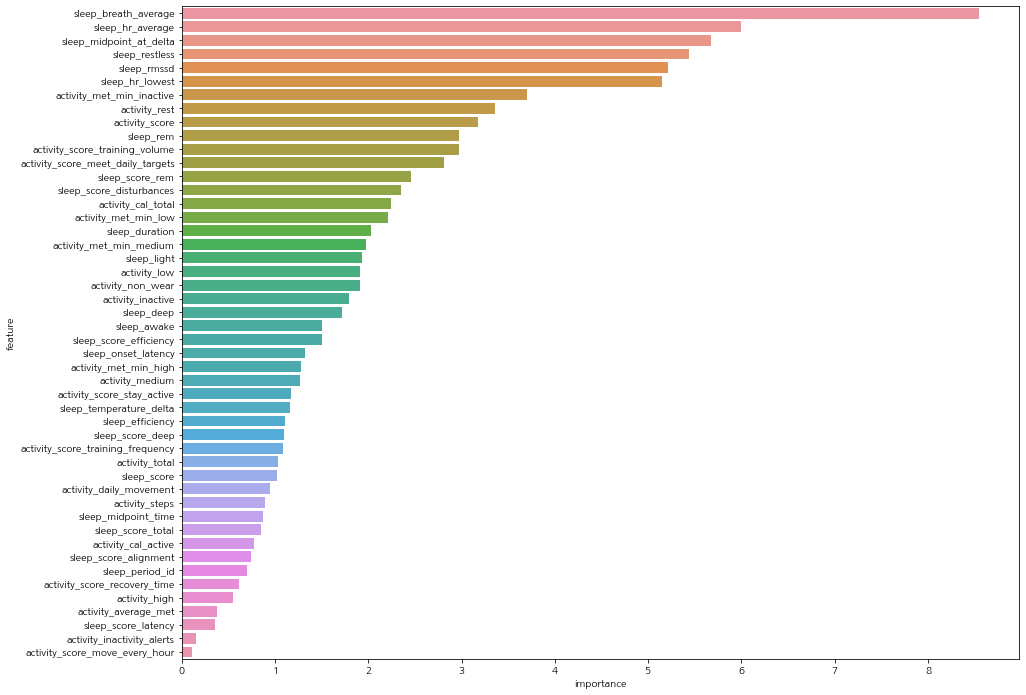

In [37]:
feature_importance = pd.DataFrame(test_X.columns, columns=["feature"])
feature_importance["importance"] = model_cat.feature_importances_
feature_importance = feature_importance.sort_values(by=["importance"], ascending=False)

plt.figure(figsize = (15,12))
sns.barplot(data=feature_importance, x="importance", y="feature")

# 6. Evaluation

- precision(정밀도) : True -> True 
- Recall(재현율) : True인 것을 맞춘 비율 
- F1 score : precision 과 recall의 조화평균

In [18]:
def show_pred(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    
    df_result = pd.DataFrame(list(zip(true_y, pred)), columns=['true_y', 'prediction'])
    return df_result
    
def show_prediction_error(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    error = pred - true_y
    plt.hist(error, bins=25)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")
    
def feature_importance(model_xgb) : 
    %matplotlib inline
    plt.rcParams['axes.unicode_minus'] = False
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = fm.FontProperties(fname=font_path).get_name()
    rc('font', family=font)

    fig, ax = plt.subplots(figsize=(10,12))
    plot_importance(model_xgb, ax=ax)
    
def graph(pred, test_label) :
    plt.figure(figsize=(16, 9))
    plt.plot(test_label, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()